##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

2021-07-16 17:48:43.921986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-16 17:48:43.922032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [3]:
annotation_file = "annotations/captions_train2014.json"
PATH = "train2014/"

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
type(annotations)

dict

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
help(random.shuffle)

Help on method shuffle in module random:

shuffle(x, random=None) method of random.Random instance
    Shuffle list x in place, and return None.
    
    Optional argument random is a 0-argument function returning a
    random float in [0.0, 1.0); if it is the default None, the
    standard random.random will be used.



In [7]:
image_paths = list(image_path_to_caption.keys())
random.seed(42)
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [8]:
train_image_paths[:3]

['train2014/COCO_train2014_000000521200.jpg',
 'train2014/COCO_train2014_000000573795.jpg',
 'train2014/COCO_train2014_000000254556.jpg']

In [9]:
from pathlib import Path

In [10]:
Path('train2014/COCO_train2014_000000521200.jpg.npy').stem

'COCO_train2014_000000521200.jpg'

In [11]:
Path('train2014/COCO_train2014_000000521200.jpg.npy').parent / Path('train2014/COCO_train2014_000000521200.jpg.npy').stem

PosixPath('train2014/COCO_train2014_000000521200.jpg')

In [12]:
Path('train2014/COCO_train2014_000000521200.jpg.npy').name

'COCO_train2014_000000521200.jpg.npy'

In [13]:
train_image_paths = []
for p in Path("train2014/").iterdir():
    if ".npy" in p.name:
        train_image_paths.append(str(p.parent / p.stem))
train_image_paths[:5]   

['train2014/COCO_train2014_000000462284.jpg',
 'train2014/COCO_train2014_000000458229.jpg',
 'train2014/COCO_train2014_000000278656.jpg',
 'train2014/COCO_train2014_000000343235.jpg',
 'train2014/COCO_train2014_000000166200.jpg']

In [14]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A woman wearing a hat while talking on a phone. <end>


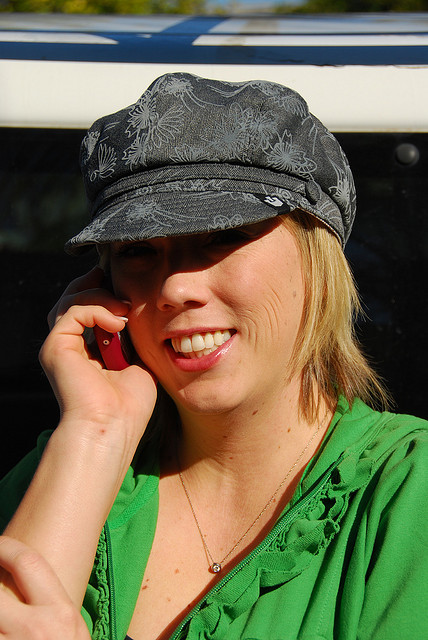

In [15]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [17]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2021-07-16 17:48:49.567425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-16 17:48:49.567485: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-16 17:48:49.567657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mushroom-x200): /proc/driver/nvidia/version does not exist


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [18]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [19]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [20]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [21]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [22]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [23]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [24]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [25]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24014, 24014, 6004, 6004)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [26]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [27]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [49]:
units

512

In [29]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [30]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [31]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [32]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [34]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [36]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [37]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [38]:
from tqdm.notebook import tqdm

In [39]:
EPOCHS = 20
every_n_batches = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset), total=num_steps):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % every_n_batches == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|          | 0/375 [00:00<?, ?it/s]

2021-07-16 17:48:54.943378: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-16 17:48:54.960871: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2493390000 Hz


Epoch 2 Batch 0 Loss 0.9174
Epoch 2 Batch 10 Loss 0.8208
Epoch 2 Batch 20 Loss 0.8499
Epoch 2 Batch 30 Loss 0.8860
Epoch 2 Batch 40 Loss 0.8539
Epoch 2 Batch 50 Loss 0.8082
Epoch 2 Batch 60 Loss 0.8741
Epoch 2 Batch 70 Loss 0.8136
Epoch 2 Batch 80 Loss 0.8223
Epoch 2 Batch 90 Loss 0.8688
Epoch 2 Batch 100 Loss 0.8369
Epoch 2 Batch 110 Loss 0.8098
Epoch 2 Batch 120 Loss 0.8230
Epoch 2 Batch 130 Loss 0.8279
Epoch 2 Batch 140 Loss 0.8309
Epoch 2 Batch 150 Loss 0.8417
Epoch 2 Batch 160 Loss 0.7321
Epoch 2 Batch 170 Loss 0.7860
Epoch 2 Batch 180 Loss 0.7518
Epoch 2 Batch 190 Loss 0.7981
Epoch 2 Batch 200 Loss 0.7850
Epoch 2 Batch 210 Loss 0.8140
Epoch 2 Batch 220 Loss 0.7781
Epoch 2 Batch 230 Loss 0.8096
Epoch 2 Batch 240 Loss 0.7462
Epoch 2 Batch 250 Loss 0.9194
Epoch 2 Batch 260 Loss 0.7665
Epoch 2 Batch 270 Loss 0.7824
Epoch 2 Batch 280 Loss 0.7620
Epoch 2 Batch 290 Loss 0.7228
Epoch 2 Batch 300 Loss 0.7011
Epoch 2 Batch 310 Loss 0.7707
Epoch 2 Batch 320 Loss 0.8425
Epoch 2 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3 Batch 0 Loss 0.7568
Epoch 3 Batch 10 Loss 0.7912
Epoch 3 Batch 20 Loss 0.6835
Epoch 3 Batch 30 Loss 0.7501
Epoch 3 Batch 40 Loss 0.8097
Epoch 3 Batch 50 Loss 0.8346
Epoch 3 Batch 60 Loss 0.7232
Epoch 3 Batch 70 Loss 0.7077
Epoch 3 Batch 80 Loss 0.7323
Epoch 3 Batch 90 Loss 0.7366
Epoch 3 Batch 100 Loss 0.7405
Epoch 3 Batch 110 Loss 0.8009
Epoch 3 Batch 120 Loss 0.6931
Epoch 3 Batch 130 Loss 0.7131
Epoch 3 Batch 140 Loss 0.7600
Epoch 3 Batch 150 Loss 0.7930
Epoch 3 Batch 160 Loss 0.7427
Epoch 3 Batch 170 Loss 0.6927
Epoch 3 Batch 180 Loss 0.6961
Epoch 3 Batch 190 Loss 0.7212
Epoch 3 Batch 200 Loss 0.7613
Epoch 3 Batch 210 Loss 0.6976
Epoch 3 Batch 220 Loss 0.7360
Epoch 3 Batch 230 Loss 0.6863
Epoch 3 Batch 240 Loss 0.6728
Epoch 3 Batch 250 Loss 0.6909
Epoch 3 Batch 260 Loss 0.6951
Epoch 3 Batch 270 Loss 0.7107
Epoch 3 Batch 280 Loss 0.7546
Epoch 3 Batch 290 Loss 0.7356
Epoch 3 Batch 300 Loss 0.7244
Epoch 3 Batch 310 Loss 0.7078
Epoch 3 Batch 320 Loss 0.7582
Epoch 3 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4 Batch 0 Loss 0.7537
Epoch 4 Batch 10 Loss 0.7070
Epoch 4 Batch 20 Loss 0.7438
Epoch 4 Batch 30 Loss 0.6605
Epoch 4 Batch 40 Loss 0.7446
Epoch 4 Batch 50 Loss 0.6603
Epoch 4 Batch 60 Loss 0.6483
Epoch 4 Batch 70 Loss 0.7271
Epoch 4 Batch 80 Loss 0.7158
Epoch 4 Batch 90 Loss 0.6289
Epoch 4 Batch 100 Loss 0.6942
Epoch 4 Batch 110 Loss 0.7006
Epoch 4 Batch 120 Loss 0.6651
Epoch 4 Batch 130 Loss 0.6579
Epoch 4 Batch 140 Loss 0.6644
Epoch 4 Batch 150 Loss 0.7201
Epoch 4 Batch 160 Loss 0.6880
Epoch 4 Batch 170 Loss 0.7121
Epoch 4 Batch 180 Loss 0.6708
Epoch 4 Batch 190 Loss 0.6424
Epoch 4 Batch 200 Loss 0.6438
Epoch 4 Batch 210 Loss 0.6235
Epoch 4 Batch 220 Loss 0.7264
Epoch 4 Batch 230 Loss 0.5951
Epoch 4 Batch 240 Loss 0.6604
Epoch 4 Batch 250 Loss 0.7394
Epoch 4 Batch 260 Loss 0.7120
Epoch 4 Batch 270 Loss 0.6197
Epoch 4 Batch 280 Loss 0.6821
Epoch 4 Batch 290 Loss 0.6526
Epoch 4 Batch 300 Loss 0.6148
Epoch 4 Batch 310 Loss 0.6419
Epoch 4 Batch 320 Loss 0.6666
Epoch 4 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5 Batch 0 Loss 0.7244
Epoch 5 Batch 10 Loss 0.6375
Epoch 5 Batch 20 Loss 0.7108
Epoch 5 Batch 30 Loss 0.6375
Epoch 5 Batch 40 Loss 0.6819
Epoch 5 Batch 50 Loss 0.6232
Epoch 5 Batch 60 Loss 0.6761
Epoch 5 Batch 70 Loss 0.6324
Epoch 5 Batch 80 Loss 0.6903
Epoch 5 Batch 90 Loss 0.6302
Epoch 5 Batch 100 Loss 0.6411
Epoch 5 Batch 110 Loss 0.6956
Epoch 5 Batch 120 Loss 0.5830
Epoch 5 Batch 130 Loss 0.6507
Epoch 5 Batch 140 Loss 0.6372
Epoch 5 Batch 150 Loss 0.6019
Epoch 5 Batch 160 Loss 0.6691
Epoch 5 Batch 170 Loss 0.6138
Epoch 5 Batch 180 Loss 0.6051
Epoch 5 Batch 190 Loss 0.6068
Epoch 5 Batch 200 Loss 0.6225
Epoch 5 Batch 210 Loss 0.6402
Epoch 5 Batch 220 Loss 0.6956
Epoch 5 Batch 230 Loss 0.6503
Epoch 5 Batch 240 Loss 0.5729
Epoch 5 Batch 250 Loss 0.6476
Epoch 5 Batch 260 Loss 0.5811
Epoch 5 Batch 270 Loss 0.6168
Epoch 5 Batch 280 Loss 0.5830
Epoch 5 Batch 290 Loss 0.6090
Epoch 5 Batch 300 Loss 0.6073
Epoch 5 Batch 310 Loss 0.6279
Epoch 5 Batch 320 Loss 0.6366
Epoch 5 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6 Batch 0 Loss 0.6489
Epoch 6 Batch 10 Loss 0.6827
Epoch 6 Batch 20 Loss 0.5960
Epoch 6 Batch 30 Loss 0.6229
Epoch 6 Batch 40 Loss 0.5947
Epoch 6 Batch 50 Loss 0.5742
Epoch 6 Batch 60 Loss 0.6099
Epoch 6 Batch 70 Loss 0.5696
Epoch 6 Batch 80 Loss 0.6610
Epoch 6 Batch 90 Loss 0.5872
Epoch 6 Batch 100 Loss 0.5649
Epoch 6 Batch 110 Loss 0.6427
Epoch 6 Batch 120 Loss 0.6413
Epoch 6 Batch 130 Loss 0.6639
Epoch 6 Batch 140 Loss 0.6258
Epoch 6 Batch 150 Loss 0.6240
Epoch 6 Batch 160 Loss 0.6377
Epoch 6 Batch 170 Loss 0.5923
Epoch 6 Batch 180 Loss 0.5984
Epoch 6 Batch 190 Loss 0.6178
Epoch 6 Batch 200 Loss 0.6074
Epoch 6 Batch 210 Loss 0.6819
Epoch 6 Batch 220 Loss 0.6693
Epoch 6 Batch 230 Loss 0.5544
Epoch 6 Batch 240 Loss 0.6540
Epoch 6 Batch 250 Loss 0.5752
Epoch 6 Batch 260 Loss 0.6206
Epoch 6 Batch 270 Loss 0.6343
Epoch 6 Batch 280 Loss 0.5719
Epoch 6 Batch 290 Loss 0.5700
Epoch 6 Batch 300 Loss 0.5691
Epoch 6 Batch 310 Loss 0.5867
Epoch 6 Batch 320 Loss 0.5684
Epoch 6 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7 Batch 0 Loss 0.6146
Epoch 7 Batch 10 Loss 0.5684
Epoch 7 Batch 20 Loss 0.5338
Epoch 7 Batch 30 Loss 0.5662
Epoch 7 Batch 40 Loss 0.5869
Epoch 7 Batch 50 Loss 0.5905
Epoch 7 Batch 60 Loss 0.5379
Epoch 7 Batch 70 Loss 0.5501
Epoch 7 Batch 80 Loss 0.5409
Epoch 7 Batch 90 Loss 0.5663
Epoch 7 Batch 100 Loss 0.5392
Epoch 7 Batch 110 Loss 0.5841
Epoch 7 Batch 120 Loss 0.5649
Epoch 7 Batch 130 Loss 0.5856
Epoch 7 Batch 140 Loss 0.5493
Epoch 7 Batch 150 Loss 0.5885
Epoch 7 Batch 160 Loss 0.5806
Epoch 7 Batch 170 Loss 0.6053
Epoch 7 Batch 180 Loss 0.5439
Epoch 7 Batch 190 Loss 0.5793
Epoch 7 Batch 200 Loss 0.6039
Epoch 7 Batch 210 Loss 0.5512
Epoch 7 Batch 220 Loss 0.5303
Epoch 7 Batch 230 Loss 0.5658
Epoch 7 Batch 240 Loss 0.5889
Epoch 7 Batch 250 Loss 0.5571
Epoch 7 Batch 260 Loss 0.5487
Epoch 7 Batch 270 Loss 0.5548
Epoch 7 Batch 280 Loss 0.5116
Epoch 7 Batch 290 Loss 0.5848
Epoch 7 Batch 300 Loss 0.5246
Epoch 7 Batch 310 Loss 0.5508
Epoch 7 Batch 320 Loss 0.5140
Epoch 7 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8 Batch 0 Loss 0.5639
Epoch 8 Batch 10 Loss 0.5206
Epoch 8 Batch 20 Loss 0.5382
Epoch 8 Batch 30 Loss 0.5309
Epoch 8 Batch 40 Loss 0.5615
Epoch 8 Batch 50 Loss 0.5588
Epoch 8 Batch 60 Loss 0.5289
Epoch 8 Batch 70 Loss 0.5476
Epoch 8 Batch 80 Loss 0.6031
Epoch 8 Batch 90 Loss 0.5037
Epoch 8 Batch 100 Loss 0.6029
Epoch 8 Batch 110 Loss 0.5490
Epoch 8 Batch 120 Loss 0.4995
Epoch 8 Batch 130 Loss 0.5180
Epoch 8 Batch 140 Loss 0.5736
Epoch 8 Batch 150 Loss 0.5271
Epoch 8 Batch 160 Loss 0.5496
Epoch 8 Batch 170 Loss 0.6064
Epoch 8 Batch 180 Loss 0.5388
Epoch 8 Batch 190 Loss 0.4907
Epoch 8 Batch 200 Loss 0.5367
Epoch 8 Batch 210 Loss 0.5396
Epoch 8 Batch 220 Loss 0.5337
Epoch 8 Batch 230 Loss 0.5232
Epoch 8 Batch 240 Loss 0.5108
Epoch 8 Batch 250 Loss 0.6213
Epoch 8 Batch 260 Loss 0.5207
Epoch 8 Batch 270 Loss 0.5171
Epoch 8 Batch 280 Loss 0.5714
Epoch 8 Batch 290 Loss 0.5182
Epoch 8 Batch 300 Loss 0.5332
Epoch 8 Batch 310 Loss 0.4898
Epoch 8 Batch 320 Loss 0.5110
Epoch 8 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9 Batch 0 Loss 0.5474
Epoch 9 Batch 10 Loss 0.5283
Epoch 9 Batch 20 Loss 0.4988
Epoch 9 Batch 30 Loss 0.4876
Epoch 9 Batch 40 Loss 0.5523
Epoch 9 Batch 50 Loss 0.5402
Epoch 9 Batch 60 Loss 0.4604
Epoch 9 Batch 70 Loss 0.5095
Epoch 9 Batch 80 Loss 0.5520
Epoch 9 Batch 90 Loss 0.4796
Epoch 9 Batch 100 Loss 0.4836
Epoch 9 Batch 110 Loss 0.4871
Epoch 9 Batch 120 Loss 0.4862
Epoch 9 Batch 130 Loss 0.4523
Epoch 9 Batch 140 Loss 0.5168
Epoch 9 Batch 150 Loss 0.4980
Epoch 9 Batch 160 Loss 0.5709
Epoch 9 Batch 170 Loss 0.5322
Epoch 9 Batch 180 Loss 0.5243
Epoch 9 Batch 190 Loss 0.4435
Epoch 9 Batch 200 Loss 0.4824
Epoch 9 Batch 210 Loss 0.5445
Epoch 9 Batch 220 Loss 0.5240
Epoch 9 Batch 230 Loss 0.4536
Epoch 9 Batch 240 Loss 0.4919
Epoch 9 Batch 250 Loss 0.4805
Epoch 9 Batch 260 Loss 0.5227
Epoch 9 Batch 270 Loss 0.4429
Epoch 9 Batch 280 Loss 0.5115
Epoch 9 Batch 290 Loss 0.5114
Epoch 9 Batch 300 Loss 0.4887
Epoch 9 Batch 310 Loss 0.4622
Epoch 9 Batch 320 Loss 0.4653
Epoch 9 Batch 330 Los

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10 Batch 0 Loss 0.5356
Epoch 10 Batch 10 Loss 0.4668
Epoch 10 Batch 20 Loss 0.5487
Epoch 10 Batch 30 Loss 0.4587
Epoch 10 Batch 40 Loss 0.4536
Epoch 10 Batch 50 Loss 0.4899
Epoch 10 Batch 60 Loss 0.5052
Epoch 10 Batch 70 Loss 0.4466
Epoch 10 Batch 80 Loss 0.5100
Epoch 10 Batch 90 Loss 0.4425
Epoch 10 Batch 100 Loss 0.5078
Epoch 10 Batch 110 Loss 0.4732
Epoch 10 Batch 120 Loss 0.4882
Epoch 10 Batch 130 Loss 0.5051
Epoch 10 Batch 140 Loss 0.4735
Epoch 10 Batch 150 Loss 0.4365
Epoch 10 Batch 160 Loss 0.5046
Epoch 10 Batch 170 Loss 0.4890
Epoch 10 Batch 180 Loss 0.5109
Epoch 10 Batch 190 Loss 0.4987
Epoch 10 Batch 200 Loss 0.4825
Epoch 10 Batch 210 Loss 0.4668
Epoch 10 Batch 220 Loss 0.4711
Epoch 10 Batch 230 Loss 0.4816
Epoch 10 Batch 240 Loss 0.4543
Epoch 10 Batch 250 Loss 0.4931
Epoch 10 Batch 260 Loss 0.4709
Epoch 10 Batch 270 Loss 0.4494
Epoch 10 Batch 280 Loss 0.4555
Epoch 10 Batch 290 Loss 0.4573
Epoch 10 Batch 300 Loss 0.4543
Epoch 10 Batch 310 Loss 0.5031
Epoch 10 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11 Batch 0 Loss 0.4618
Epoch 11 Batch 10 Loss 0.4383
Epoch 11 Batch 20 Loss 0.4512
Epoch 11 Batch 30 Loss 0.4989
Epoch 11 Batch 40 Loss 0.5001
Epoch 11 Batch 50 Loss 0.4123
Epoch 11 Batch 60 Loss 0.4541
Epoch 11 Batch 70 Loss 0.4275
Epoch 11 Batch 80 Loss 0.4867
Epoch 11 Batch 90 Loss 0.4535
Epoch 11 Batch 100 Loss 0.4415
Epoch 11 Batch 110 Loss 0.4467
Epoch 11 Batch 120 Loss 0.4346
Epoch 11 Batch 130 Loss 0.4755
Epoch 11 Batch 140 Loss 0.4392
Epoch 11 Batch 150 Loss 0.4665
Epoch 11 Batch 160 Loss 0.4733
Epoch 11 Batch 170 Loss 0.4848
Epoch 11 Batch 180 Loss 0.4770
Epoch 11 Batch 190 Loss 0.4422
Epoch 11 Batch 200 Loss 0.4635
Epoch 11 Batch 210 Loss 0.4676
Epoch 11 Batch 220 Loss 0.4513
Epoch 11 Batch 230 Loss 0.4680
Epoch 11 Batch 240 Loss 0.4360
Epoch 11 Batch 250 Loss 0.4285
Epoch 11 Batch 260 Loss 0.4430
Epoch 11 Batch 270 Loss 0.4660
Epoch 11 Batch 280 Loss 0.4251
Epoch 11 Batch 290 Loss 0.4957
Epoch 11 Batch 300 Loss 0.4584
Epoch 11 Batch 310 Loss 0.4174
Epoch 11 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12 Batch 0 Loss 0.4537
Epoch 12 Batch 10 Loss 0.4614
Epoch 12 Batch 20 Loss 0.4247
Epoch 12 Batch 30 Loss 0.4086
Epoch 12 Batch 40 Loss 0.4562
Epoch 12 Batch 50 Loss 0.4487
Epoch 12 Batch 60 Loss 0.4736
Epoch 12 Batch 70 Loss 0.4687
Epoch 12 Batch 80 Loss 0.4183
Epoch 12 Batch 90 Loss 0.4379
Epoch 12 Batch 100 Loss 0.4114
Epoch 12 Batch 110 Loss 0.4113
Epoch 12 Batch 120 Loss 0.4260
Epoch 12 Batch 130 Loss 0.4214
Epoch 12 Batch 140 Loss 0.4262
Epoch 12 Batch 150 Loss 0.4384
Epoch 12 Batch 160 Loss 0.4393
Epoch 12 Batch 170 Loss 0.4823
Epoch 12 Batch 180 Loss 0.3964
Epoch 12 Batch 190 Loss 0.4048
Epoch 12 Batch 200 Loss 0.4295
Epoch 12 Batch 210 Loss 0.4475
Epoch 12 Batch 220 Loss 0.4927
Epoch 12 Batch 230 Loss 0.4247
Epoch 12 Batch 240 Loss 0.4279
Epoch 12 Batch 250 Loss 0.5093
Epoch 12 Batch 260 Loss 0.4050
Epoch 12 Batch 270 Loss 0.3978
Epoch 12 Batch 280 Loss 0.4034
Epoch 12 Batch 290 Loss 0.4051
Epoch 12 Batch 300 Loss 0.3911
Epoch 12 Batch 310 Loss 0.4475
Epoch 12 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13 Batch 0 Loss 0.4363
Epoch 13 Batch 10 Loss 0.4042
Epoch 13 Batch 20 Loss 0.4160
Epoch 13 Batch 30 Loss 0.4283
Epoch 13 Batch 40 Loss 0.3957
Epoch 13 Batch 50 Loss 0.3993
Epoch 13 Batch 60 Loss 0.4318
Epoch 13 Batch 70 Loss 0.4225
Epoch 13 Batch 80 Loss 0.4381
Epoch 13 Batch 90 Loss 0.3965
Epoch 13 Batch 100 Loss 0.4500
Epoch 13 Batch 110 Loss 0.4344
Epoch 13 Batch 120 Loss 0.4535
Epoch 13 Batch 130 Loss 0.4082
Epoch 13 Batch 140 Loss 0.4132
Epoch 13 Batch 150 Loss 0.4301
Epoch 13 Batch 160 Loss 0.3955
Epoch 13 Batch 170 Loss 0.3869
Epoch 13 Batch 180 Loss 0.3928
Epoch 13 Batch 190 Loss 0.3986
Epoch 13 Batch 200 Loss 0.3925
Epoch 13 Batch 210 Loss 0.4199
Epoch 13 Batch 220 Loss 0.4005
Epoch 13 Batch 230 Loss 0.3764
Epoch 13 Batch 240 Loss 0.4228
Epoch 13 Batch 250 Loss 0.4342
Epoch 13 Batch 260 Loss 0.3804
Epoch 13 Batch 270 Loss 0.4241
Epoch 13 Batch 280 Loss 0.4185
Epoch 13 Batch 290 Loss 0.3666
Epoch 13 Batch 300 Loss 0.4114
Epoch 13 Batch 310 Loss 0.3663
Epoch 13 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14 Batch 0 Loss 0.3849
Epoch 14 Batch 10 Loss 0.4036
Epoch 14 Batch 20 Loss 0.4460
Epoch 14 Batch 30 Loss 0.4099
Epoch 14 Batch 40 Loss 0.4147
Epoch 14 Batch 50 Loss 0.3950
Epoch 14 Batch 60 Loss 0.3605
Epoch 14 Batch 70 Loss 0.4034
Epoch 14 Batch 80 Loss 0.3742
Epoch 14 Batch 90 Loss 0.3807
Epoch 14 Batch 100 Loss 0.3570
Epoch 14 Batch 110 Loss 0.3963
Epoch 14 Batch 120 Loss 0.4294
Epoch 14 Batch 130 Loss 0.3835
Epoch 14 Batch 140 Loss 0.4363
Epoch 14 Batch 150 Loss 0.3619
Epoch 14 Batch 160 Loss 0.4007
Epoch 14 Batch 170 Loss 0.3799
Epoch 14 Batch 180 Loss 0.3807
Epoch 14 Batch 190 Loss 0.3838
Epoch 14 Batch 200 Loss 0.3977
Epoch 14 Batch 210 Loss 0.4277
Epoch 14 Batch 220 Loss 0.4164
Epoch 14 Batch 230 Loss 0.4211
Epoch 14 Batch 240 Loss 0.4231
Epoch 14 Batch 250 Loss 0.3745
Epoch 14 Batch 260 Loss 0.3609
Epoch 14 Batch 270 Loss 0.4017
Epoch 14 Batch 280 Loss 0.3869
Epoch 14 Batch 290 Loss 0.3914
Epoch 14 Batch 300 Loss 0.3563
Epoch 14 Batch 310 Loss 0.3876
Epoch 14 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15 Batch 0 Loss 0.4268
Epoch 15 Batch 10 Loss 0.4021
Epoch 15 Batch 20 Loss 0.4028
Epoch 15 Batch 30 Loss 0.4118
Epoch 15 Batch 40 Loss 0.3780
Epoch 15 Batch 50 Loss 0.3850
Epoch 15 Batch 60 Loss 0.3734
Epoch 15 Batch 70 Loss 0.3967
Epoch 15 Batch 80 Loss 0.3696
Epoch 15 Batch 90 Loss 0.3838
Epoch 15 Batch 100 Loss 0.3858
Epoch 15 Batch 110 Loss 0.3702
Epoch 15 Batch 120 Loss 0.4273
Epoch 15 Batch 130 Loss 0.3760
Epoch 15 Batch 140 Loss 0.3591
Epoch 15 Batch 150 Loss 0.3638
Epoch 15 Batch 160 Loss 0.3919
Epoch 15 Batch 170 Loss 0.3896
Epoch 15 Batch 180 Loss 0.3502
Epoch 15 Batch 190 Loss 0.3484
Epoch 15 Batch 200 Loss 0.3723
Epoch 15 Batch 210 Loss 0.4445
Epoch 15 Batch 220 Loss 0.3826
Epoch 15 Batch 230 Loss 0.3722
Epoch 15 Batch 240 Loss 0.3517
Epoch 15 Batch 250 Loss 0.3724
Epoch 15 Batch 260 Loss 0.3692
Epoch 15 Batch 270 Loss 0.3492
Epoch 15 Batch 280 Loss 0.3687
Epoch 15 Batch 290 Loss 0.3378
Epoch 15 Batch 300 Loss 0.3454
Epoch 15 Batch 310 Loss 0.3571
Epoch 15 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 16 Batch 0 Loss 0.4002
Epoch 16 Batch 10 Loss 0.3538
Epoch 16 Batch 20 Loss 0.3779
Epoch 16 Batch 30 Loss 0.3661
Epoch 16 Batch 40 Loss 0.3638
Epoch 16 Batch 50 Loss 0.3490
Epoch 16 Batch 60 Loss 0.3988
Epoch 16 Batch 70 Loss 0.3511
Epoch 16 Batch 80 Loss 0.3574
Epoch 16 Batch 90 Loss 0.3867
Epoch 16 Batch 100 Loss 0.3749
Epoch 16 Batch 110 Loss 0.3586
Epoch 16 Batch 120 Loss 0.3384
Epoch 16 Batch 130 Loss 0.3431
Epoch 16 Batch 140 Loss 0.3803
Epoch 16 Batch 150 Loss 0.3641
Epoch 16 Batch 160 Loss 0.3520
Epoch 16 Batch 170 Loss 0.3597
Epoch 16 Batch 180 Loss 0.3778
Epoch 16 Batch 190 Loss 0.3300
Epoch 16 Batch 200 Loss 0.3420
Epoch 16 Batch 210 Loss 0.3714
Epoch 16 Batch 220 Loss 0.3660
Epoch 16 Batch 230 Loss 0.3191
Epoch 16 Batch 240 Loss 0.3145
Epoch 16 Batch 250 Loss 0.3229
Epoch 16 Batch 260 Loss 0.3494
Epoch 16 Batch 270 Loss 0.3421
Epoch 16 Batch 280 Loss 0.3484
Epoch 16 Batch 290 Loss 0.3464
Epoch 16 Batch 300 Loss 0.3546
Epoch 16 Batch 310 Loss 0.3134
Epoch 16 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 17 Batch 0 Loss 0.3313
Epoch 17 Batch 10 Loss 0.3541
Epoch 17 Batch 20 Loss 0.3318
Epoch 17 Batch 30 Loss 0.3509
Epoch 17 Batch 40 Loss 0.3779
Epoch 17 Batch 50 Loss 0.3536
Epoch 17 Batch 60 Loss 0.3021
Epoch 17 Batch 70 Loss 0.3331
Epoch 17 Batch 80 Loss 0.3450
Epoch 17 Batch 90 Loss 0.3584
Epoch 17 Batch 100 Loss 0.2897
Epoch 17 Batch 110 Loss 0.3108
Epoch 17 Batch 120 Loss 0.3389
Epoch 17 Batch 130 Loss 0.3624
Epoch 17 Batch 140 Loss 0.3453
Epoch 17 Batch 150 Loss 0.3341
Epoch 17 Batch 160 Loss 0.3247
Epoch 17 Batch 170 Loss 0.3611
Epoch 17 Batch 180 Loss 0.2999
Epoch 17 Batch 190 Loss 0.3316
Epoch 17 Batch 200 Loss 0.2999
Epoch 17 Batch 210 Loss 0.3126
Epoch 17 Batch 220 Loss 0.3298
Epoch 17 Batch 230 Loss 0.3489
Epoch 17 Batch 240 Loss 0.3323
Epoch 17 Batch 250 Loss 0.3531
Epoch 17 Batch 260 Loss 0.3374
Epoch 17 Batch 270 Loss 0.3119
Epoch 17 Batch 280 Loss 0.3097
Epoch 17 Batch 290 Loss 0.3107
Epoch 17 Batch 300 Loss 0.3429
Epoch 17 Batch 310 Loss 0.3339
Epoch 17 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 18 Batch 0 Loss 0.3237
Epoch 18 Batch 10 Loss 0.3041
Epoch 18 Batch 20 Loss 0.3060
Epoch 18 Batch 30 Loss 0.3624
Epoch 18 Batch 40 Loss 0.3660
Epoch 18 Batch 50 Loss 0.3810
Epoch 18 Batch 60 Loss 0.3416
Epoch 18 Batch 70 Loss 0.3350
Epoch 18 Batch 80 Loss 0.3285
Epoch 18 Batch 90 Loss 0.3269
Epoch 18 Batch 100 Loss 0.3237
Epoch 18 Batch 110 Loss 0.3191
Epoch 18 Batch 120 Loss 0.3061
Epoch 18 Batch 130 Loss 0.3190
Epoch 18 Batch 140 Loss 0.3107
Epoch 18 Batch 150 Loss 0.3601
Epoch 18 Batch 160 Loss 0.3041
Epoch 18 Batch 170 Loss 0.3120
Epoch 18 Batch 180 Loss 0.3083
Epoch 18 Batch 190 Loss 0.2852
Epoch 18 Batch 200 Loss 0.3070
Epoch 18 Batch 210 Loss 0.3038
Epoch 18 Batch 220 Loss 0.3306
Epoch 18 Batch 230 Loss 0.2941
Epoch 18 Batch 240 Loss 0.3103
Epoch 18 Batch 250 Loss 0.3028
Epoch 18 Batch 260 Loss 0.3383
Epoch 18 Batch 270 Loss 0.3028
Epoch 18 Batch 280 Loss 0.3330
Epoch 18 Batch 290 Loss 0.3281
Epoch 18 Batch 300 Loss 0.3033
Epoch 18 Batch 310 Loss 0.3177
Epoch 18 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 19 Batch 0 Loss 0.2972
Epoch 19 Batch 10 Loss 0.3354
Epoch 19 Batch 20 Loss 0.3263
Epoch 19 Batch 30 Loss 0.3125
Epoch 19 Batch 40 Loss 0.2877
Epoch 19 Batch 50 Loss 0.3418
Epoch 19 Batch 60 Loss 0.2757
Epoch 19 Batch 70 Loss 0.3096
Epoch 19 Batch 80 Loss 0.2939
Epoch 19 Batch 90 Loss 0.2859
Epoch 19 Batch 100 Loss 0.3118
Epoch 19 Batch 110 Loss 0.2812
Epoch 19 Batch 120 Loss 0.3084
Epoch 19 Batch 130 Loss 0.2870
Epoch 19 Batch 140 Loss 0.2951
Epoch 19 Batch 150 Loss 0.3357
Epoch 19 Batch 160 Loss 0.2816
Epoch 19 Batch 170 Loss 0.3138
Epoch 19 Batch 180 Loss 0.2900
Epoch 19 Batch 190 Loss 0.2803
Epoch 19 Batch 200 Loss 0.3079
Epoch 19 Batch 210 Loss 0.2901
Epoch 19 Batch 220 Loss 0.2873
Epoch 19 Batch 230 Loss 0.3101
Epoch 19 Batch 240 Loss 0.2723
Epoch 19 Batch 250 Loss 0.3158
Epoch 19 Batch 260 Loss 0.2864
Epoch 19 Batch 270 Loss 0.2700
Epoch 19 Batch 280 Loss 0.2714
Epoch 19 Batch 290 Loss 0.2859
Epoch 19 Batch 300 Loss 0.2775
Epoch 19 Batch 310 Loss 0.3203
Epoch 19 Batch 320 

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 20 Batch 0 Loss 0.3025
Epoch 20 Batch 10 Loss 0.2995
Epoch 20 Batch 20 Loss 0.3390
Epoch 20 Batch 30 Loss 0.3165
Epoch 20 Batch 40 Loss 0.2967
Epoch 20 Batch 50 Loss 0.3064
Epoch 20 Batch 60 Loss 0.2852
Epoch 20 Batch 70 Loss 0.2933
Epoch 20 Batch 80 Loss 0.3274
Epoch 20 Batch 90 Loss 0.2958
Epoch 20 Batch 100 Loss 0.3148
Epoch 20 Batch 110 Loss 0.2763
Epoch 20 Batch 120 Loss 0.2894
Epoch 20 Batch 130 Loss 0.2707
Epoch 20 Batch 140 Loss 0.2791
Epoch 20 Batch 150 Loss 0.2981
Epoch 20 Batch 160 Loss 0.3154
Epoch 20 Batch 170 Loss 0.2962
Epoch 20 Batch 180 Loss 0.2720
Epoch 20 Batch 190 Loss 0.2815
Epoch 20 Batch 200 Loss 0.3225
Epoch 20 Batch 210 Loss 0.2785
Epoch 20 Batch 220 Loss 0.3061
Epoch 20 Batch 230 Loss 0.2798
Epoch 20 Batch 240 Loss 0.3248
Epoch 20 Batch 250 Loss 0.2772
Epoch 20 Batch 260 Loss 0.2748
Epoch 20 Batch 270 Loss 0.2919
Epoch 20 Batch 280 Loss 0.3052
Epoch 20 Batch 290 Loss 0.2733
Epoch 20 Batch 300 Loss 0.2627
Epoch 20 Batch 310 Loss 0.3004
Epoch 20 Batch 320 

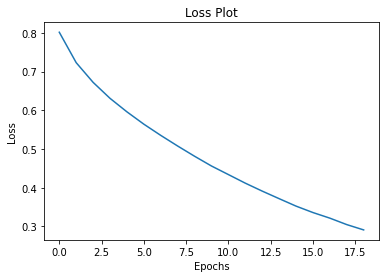

In [40]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [42]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> this is a large room outfitted with 2 sets of bunk beds <end>
Prediction Caption: a table and their picture are shown behind the wall surrounded by side <end>


/tmp/ipykernel_10274/162377284.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i+1)


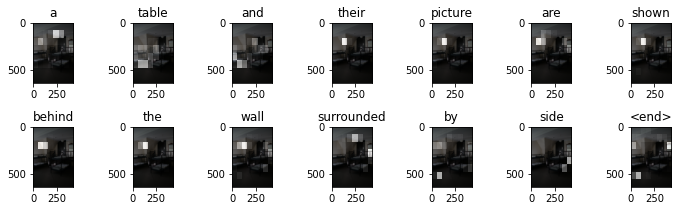

In [43]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: a man surfing a wave on a surf board <end>


/tmp/ipykernel_10274/162377284.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i+1)


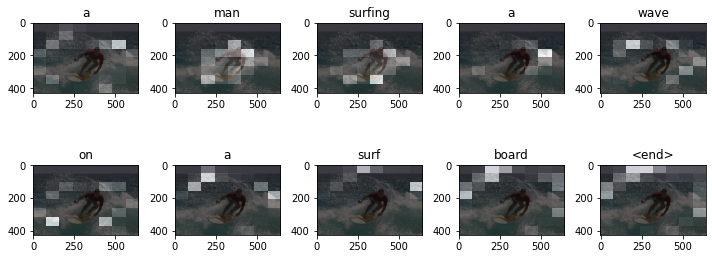

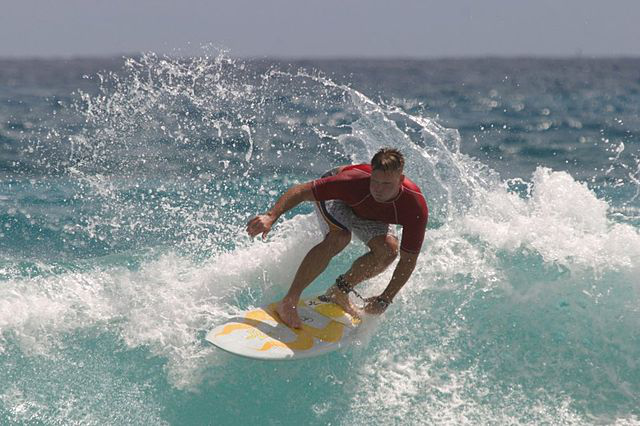

In [48]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.